In [68]:
%run DL_func.ipynb

In [69]:
from sklearn.metrics import r2_score
import pdb # for NN
import matplotlib.pyplot as plt
from torch.optim import Adam # for NN


# Notebook Overview

In this notebook we will be reproducing a subset of the methods listed in the paper *Invariant Causal Representation Learning for Out-of-Distribution Generalization*. Mainly, the goal of this notebook, as well as the subset of the paper mentioned, is to show the difference in performance when using different VAE-based models as part of the *iCARL* algorithm introduced in the paper. 

As we described in our final deliverable (which can be found in this repo), the authors of the paper argue from a theoretical mathematical perspective that VAE cannot recreate the true prior distribution and thus cannot be used to predict Y using the *iCARL* meta-algorithm - while i-VAE can in cases where the priors are not dependent, and NF-VAE can even in cases where they are dependent. 

This notebook showcases the ability of the different VAE neural networks to separate the latent variables, and thus identify them. We do so by first creating synthetic data for which we know the true latent variables and their distributions. Then, we run the three mentioned VAE neural nets on them. We evaluate the results using the same methods as in the paper: calculating and comparing the Mean Correlation Coefficient (MCC) as well as plotting the latent variables. 

# 1. Data Generation

The first step consists of generating the synthetic data. The data is generated from the graph shown belown. Z denotes the unobserved latent variables, Y is the target variable which will be assumed observed (i.e. in the cow/camel classification problem 'Y' will correspond to the label 'cow' / 'camel'). X is the observed features as is generated from Z via a neural network. In the cow / camel classification problem 'X' would correspond to the actual image. Finally, an environment variable E is introduced. The environment determines the mean of the gaussian distribution the Z's are drawn from. The generative process for each of the variables is as follows:

$$Z_1 = \mathcal{N}(E, \sigma=1)$$
$$Z_2 = \mathcal{N}(2E, \sigma=2)$$
$$Y = \mathcal{N}(\alpha_1 \cdot Z_1+\alpha_2 \cdot Z_2, \sigma=1)$$
$$Y = \mathcal{N}(\alpha_3 \cdot Y, \sigma=1)$$
$$X = g(Z_1, Z_2, Z_3)$$

Where g is a randomly initialized neural network. All of the alphas are in this case set to 1.

First off, the Y's and Z's are generated from 4 different environments. 1000 samples from each environment is drawn. 

In [70]:
E_choice, Env, Y, Z = generate_z_and_y(np.array([0.2, 2, 3, 5]), 4000)

Samples from the generative process is shown in the below dataframe along with markers of which environment a sample was drawn from (variable $E_{choice}$) and the corresponding 'mean' of that environment ($E$).

In [71]:
df=pd.concat([p(Z), p(Y), p(Env), p(E_choice)],axis=1) # p function converts to pandas dataframe
df.columns = ['Z1', 'Z2', 'Z3', 'Y', 'Env_mean', 'Env'] # name columns
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'} #set color scheme
m=df['Env'].map(colors)
df['c']=m # map colors to environments
tdf=df
#df.round(2)

The below figure shows a 3d-plot of the samples in (Z1, Z2, Z3)-space coloured by environment. Use matplotlib qt instead of inline if you'd like to be able to rotate the plot etc.

C:\Users\mathi\AppData\Local\Temp/ipykernel_25176/3887001011.py:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


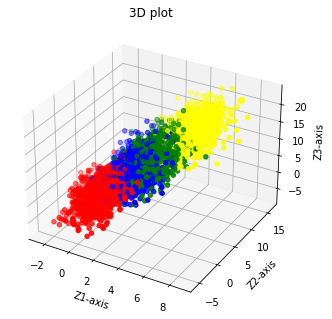

In [72]:
# for creating a responsive plot
#%matplotlib qt
%matplotlib inline

plot_latent_3d(df, m)

Finally, the observed X-values are generated via a randomly initialized neural network with 6 hidden units and 10 output units. Since the X-values are dependent on the latent variables, we will generate them twice: once for our test case of having three latent variables and once for our test case of having two latent variables. 

# 2. Testing models in the 3 Z-case #
This section uses synthetic data with 3 latent variables where one is a child of Y. 

First, we will create the X data and set up data to be input in the neural networks. For the data to be used, it must be made into a Pytorch dataset and put into a data loader.

In [73]:
# Generate X from Z
net=Net(3, 6, 10)
X=net(torch.from_numpy(Z.astype("float32"))).detach().numpy()

In [74]:
# Setup loaders for NN input
dset = EnvDataset(X[:2000],Y[:2000],E_choice[:2000])
train_loader = DataLoader(dset, batch_size=128, drop_last=True)
dset = EnvDataset(X[2000:],Y[2000:],E_choice[2000:])
test_loader = DataLoader(dset, batch_size=128, drop_last=True)
x,y,e = next(iter(train_loader))

In [75]:
z_dim = 3 # 3 latent variables 
x_y_e = 15
x_dim = 10 # 10 output units for X (10 X variables)
ye_dim = 5
y_dim = 1

## 2.1 iVAE ##

### 2.1.1 Setting up the iVAE code ###
The following block defines the iVAE, which will be testing the performance of. iVAE varies from VAE in that we are using Y and E as conditions to the prior probability. 

 Collapse this block if you'd just like to move on and see the results.

In [76]:

class iVAE(nn.Module):
    def __init__(self, x, y, e, input_size, output_size, input_size_de, output_size_de, input_size_pr, output_size_pr, beta=1):
        super().__init__()
        # Encoder
        self.func_en = nn.Sequential(
                nn.Linear(in_features=input_size, out_features=6),
                nn.ReLU(),
                nn.Linear(in_features=6, out_features=2*output_size)
            )
        
        # Decoder
        self.func_de = nn.Sequential(
                nn.Linear(in_features=input_size_de, out_features=6),
                nn.ReLU(),
                nn.Linear(in_features=6, out_features=output_size_de)
            )
        
        # MLP for Prior Distribution
        self.func_prior = nn.Sequential(
                nn.Linear(in_features=input_size_pr, out_features=6),
                nn.ReLU(),
                nn.Linear(in_features=6, out_features=output_size_pr*2)
            )
        
        self.normal_dist = Normal_dist()
        
        
    
    def forward(self, x, y, e, beta=1):
        # Format input
        xye=torch.cat((x, y, e), 1)
        
        # Get encoder params
        z_usigma = self.func_en(xye) # run encoder with formatted input
        zu, zsigma = z_usigma.chunk(2, dim = -1) # Get mu and sigma
        zsigma = zsigma.exp() # take exponent of returned log sigma parameter
        encoder_params = zu, zsigma

        # Sample Z
        z = self.normal_dist.sample(zu, zsigma)

        # Get decoder params
        de_u = self.func_de(z)
        
        # Get prior params
        ye = torch.cat((y, e), 1) #format input to prior MLP
        prior_u, prior_sigma = self.func(ye).chunk(2, axis = -1)
        prior_sigma = prior_sigma.exp()
        
        return zu, zsigma, de_u, prior_u, prior_sigma, z
    
    def elbo(self, x, y, e, beta=1):
        zu, zsigma, de_u, prior_u, prior_sigma, z = self.forward(x, y, e)
        
        # Samples from distributions with the acquired parameters
        lvar = 0.01*torch.ones(1).to('cpu')
        log_px_z = self.normal_dist.log_pdf(x, de_u, lvar) # p(x | u, sigma)
        log_qz_xye = self.normal_dist.log_pdf(z, zu, zsigma)
        log_pz_ye = self.normal_dist.log_pdf(z, prior_u, prior_sigma)

        # And compute kl and elbo
        kl = -log_qz_xye + log_pz_ye

        elbo = log_px_z + beta*kl

        return elbo.mean()

    
    

### 2.1.2 iVAE results #

Epoch 20 of 1000
Train loss: tensor(47.4982)
Epoch 40 of 1000
Train loss: tensor(30.0590)
Epoch 60 of 1000
Train loss: tensor(21.0493)
Epoch 80 of 1000
Train loss: tensor(11.6186)
Epoch 100 of 1000
Train loss: tensor(1.6298)
Epoch 120 of 1000
Train loss: tensor(-2.4286)
Epoch 140 of 1000
Train loss: tensor(-5.2238)
Epoch 160 of 1000
Train loss: tensor(-6.6287)
Epoch 180 of 1000
Train loss: tensor(-7.0710)
Epoch 200 of 1000
Train loss: tensor(-7.3041)
Epoch 220 of 1000
Train loss: tensor(-7.4367)
Epoch 240 of 1000
Train loss: tensor(-7.4723)
Epoch 260 of 1000
Train loss: tensor(-7.5816)
Epoch 280 of 1000
Train loss: tensor(-7.6062)
Epoch 300 of 1000
Train loss: tensor(-7.6382)
Epoch 320 of 1000
Train loss: tensor(-7.6967)
Epoch 340 of 1000
Train loss: tensor(-7.7382)
Epoch 360 of 1000
Train loss: tensor(-7.7320)
Epoch 380 of 1000
Train loss: tensor(-7.7509)
Epoch 400 of 1000
Train loss: tensor(-7.7610)
Epoch 420 of 1000
Train loss: tensor(-7.7781)
Epoch 440 of 1000
Train loss: tensor(-7

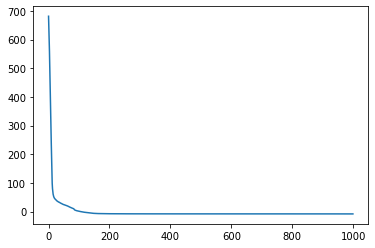

In [77]:
net_ivae=iVAE(x.float(), y.float(), e.float(), x_y_e, z_dim, z_dim, x_dim, 5, 3, beta=1)
x,y,e = next(iter(train_loader))
#elbo = net_ivae.elbo(x.float(),y.float(),e.float())

optimizer = Adam(net_ivae.parameters(), lr=1e-3)

epochs = 10
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)

for epoch in range(epochs):
    epoch_loss = 0
    #if epoch < 20:
    #    beta = 10
    #else:
    #    beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss = net_ivae.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)
    
plt.plot(train_loss)
plt.show()


In [78]:
# get z
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 3))
envs_samp = np.zeros((len(train_loader)*128, 4))
i = 0
for x,y,e in loader:
    _, _, _, _, _, z = net_ivae.forward(x.float(), y.float(), e.float(), beta=1)
    latent_variables[i*128:i*128+128,:] = z.detach()
    envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
    i+=1
    
df_ivae=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
df_ivae.columns = ['Z1', 'Z2', 'Z3', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m_ivae=df_ivae['Env'].map(colors)
df_ivae['c']=m
#df.round(2)

In [79]:
## Uncomment the qt line if you'd like to be able to rotate the plot
#%matplotlib qt
#plot_latent_3d(df_ivae, m_ivae)

In [80]:
# Merge dataframes together
pdf_ivae=df_ivae[['Z1', 'Z2', 'Z3']]
pdf_ivae.columns = ['pZ1', 'pZ2', 'pZ3']
cdf_ivae=tdf[['Z1', 'Z2', 'Z3']].iloc[2000:3920,:]
cdf_ivae['pZ1']=pdf_ivae['pZ1'].values
cdf_ivae['pZ2']=pdf_ivae['pZ2'].values
cdf_ivae['pZ3']=pdf_ivae['pZ3'].values

In [81]:
# Calculate MCC
mcc_ivae=MCC(cdf_ivae.iloc[:,:3].values, pdf_ivae.values)
MCC(cdf_ivae.iloc[:,:3].values, pdf_ivae.values)

[0.9614300579158648, 0.4603693842823111, 0.9878037970322632]
[0.9614300579158648, 0.4603693842823111, 0.9878037970322632]


0.8032010797434798

## 2.2 VAE ##

### 2.2.1 Setting up VAE code ###
In this section we will be defining and training the VAE which we will be testing the performance of. 

Skip subsection at your own leisure.

In [82]:
class VAE(nn.Module):
    def __init__(self, x, y, e, input_size, output_size, input_size_de, output_size_de, input_size_pr, output_size_pr, beta=1):
        super().__init__()
        # prior_params
        self.prior_mean = torch.zeros(1).to('cpu')
        self.logl = torch.zeros(1).to('cpu')
        
        # Encoder
        self.func_en = nn.Sequential(
                nn.Linear(in_features=input_size, out_features=6),
                nn.ReLU(),
                nn.Linear(in_features=6, out_features=2*output_size)
            )
        
        # Decoder
        self.func_de = nn.Sequential(
                nn.Linear(in_features=input_size_de, out_features=6),
                nn.ReLU(),
                nn.Linear(in_features=6, out_features=output_size_de)
            )
        
        # Prior
        self.func_prior = nn.Sequential(
                nn.Linear(in_features=input_size_pr, out_features=6),
                nn.ReLU(),
                nn.Linear(in_features=6, out_features=output_size_pr*2)
            )
        
        self.normal_dist = Normal_dist() # call function to define normal distribution, like in Week 7
        
    def reparametrize(self, mu, logvar):
        """Reparameterization trick from Week 7"""
        std = torch.exp(0.5*logvar)
        eps = self.normal_dist.sample(mu, std)
        return mu + eps * std
    
    def prior_params(self):
        """Returns the prior parameters"""
        return self.prior_mean, self.logl.exp()
    
    def forward(self, x, y, e, beta=1):
        """Forward Pass of iVAE"""
        # Format input
        xye=torch.cat((x, y, e), 1)
        
        # Get prior params
        prior_params = self.prior_params()
        
        # Get encoder params
        z_usigma = self.func_en(xye)
        zu, zsigma = z_usigma.chunk(2, dim = -1) # Get mu and sigma
        
        #zsigma = zsigma.exp()
        encoder_params = zu, zsigma

        # Sample Z
        z = self.reparametrize(zu, zsigma)

        # Get decoder params
        de_u = self.func_de(z)
        
        return zu, zsigma, de_u, z, prior_params

    
    def elbo(self, x, y, e, beta=1):
        """ELBO function for NN training, 
        now with the prior coming from a conditioned distribution"""
        zu, zsigma, de_u, z, prior_params = self.forward(x, y, e)
        # Samples from distributions with the acquired parameters
        lvar = 0.01*torch.ones(1).to('cpu')
        log_px_z = self.normal_dist.log_pdf(x, de_u, lvar) # p(x | u, sigma)
        log_qz_xy = self.normal_dist.log_pdf(z, zu, zsigma.exp())
        log_pz_ye = self.normal_dist.log_pdf(z, *prior_params)

        # And compute kl and elbo
        kl = -log_qz_xy + log_pz_ye

        elbo = log_px_z + beta*kl
        #pdb.set_trace()

        return elbo.mean()    

#### Training

In [83]:
# Define hyperparameters
z_dim=3
x_y_e=15
x_dim=10
net_vae=VAE(x.float(), y.float(), e.float(), x_y_e, z_dim, z_dim, x_dim, 5, z_dim, beta=1)

# Define optimizer
optimizer = Adam(net_vae.parameters(), lr=1e-3)

# Set # of epochs, and variables to store outputs in
epochs = 1000
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)

# Train
for epoch in range(epochs):
    epoch_loss = 0
    if epoch < 20:
        beta = 10
    else:
        beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss = net_vae.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)
    
plt.plot(train_loss)
plt.show()

C:\Users\mathi\anaconda3\envs\BackDec2022\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class '__main__.Normal_dist'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Epoch 20 of 1000
Train loss: tensor(154.9014)
Epoch 40 of 1000
Train loss: tensor(34.1500)
Epoch 60 of 1000
Train loss: tensor(19.3812)
Epoch 80 of 1000
Train loss: tensor(10.0514)
Epoch 100 of 1000
Train loss: tensor(0.9132)
Epoch 120 of 1000
Train loss: tensor(-2.8894)
Epoch 140 of 1000
Train loss: tensor(-4.2243)
Epoch 160 of 1000
Train loss: tensor(-4.8181)
Epoch 180 of 1000
Train loss: tensor(-5.1290)
Epoch 200 of 1000
Train loss: tensor(-5.4605)
Epoch 220 of 1000
Train loss: tensor(-5.6253)
Epoch 240 of 1000
Train loss: tensor(-5.9988)
Epoch 260 of 1000
Train loss: tensor(-6.3412)
Epoch 280 of 1000
Train loss: tensor(-6.7276)
Epoch 300 of 1000
Train loss: tensor(-6.8759)
Epoch 320 of 1000
Train loss: tensor(-7.0420)
Epoch 340 of 1000
Train loss: tensor(-7.0643)
Epoch 360 of 1000
Train loss: tensor(-7.1477)
Epoch 380 of 1000
Train loss: tensor(-7.2267)
Epoch 400 of 1000
Train loss: tensor(-7.3200)
Epoch 420 of 1000
Train loss: tensor(-7.3790)
Epoch 440 of 1000
Train loss: tensor(-

### 2.2.2 VAE results ###

Here, we test the VAE, and extract the latent variables. 

In [84]:

# get z
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 3))
envs_samp = np.zeros((len(train_loader)*128, 4))
i = 0
for x,y,e in loader:
    #_, _, _, _, _, z = net.forward(x.float(), y.float(), e.float(), beta=1)
    zu, zsigma, de_u, z, prior_params = net_vae.forward(x.float(), y.float(), e.float(), beta=1)
    latent_variables[i*128:i*128+128,:] = z.detach() # put the latent variables for this load in the output dataframe
    envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int) # same for environment
    i+=1

# Merge results and format
df_vae=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1) 
df_vae.columns = ['Z1', 'Z2', 'Z3', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m_vae=df_vae['Env'].map(colors)
df_vae['c']=m
#df.round(2)

In [85]:
## Uncomment the qt line if you'd like to be able to rotate the plot
#%matplotlib qt
#plot_latent_3d(df_vae, m_vae)

In [86]:
pdf_vae=df_vae[['Z1', 'Z2', 'Z3']] # extract probability density function of latent vars
pdf_vae.columns = ['pZ1', 'pZ2', 'pZ3']
cdf_vae=tdf[['Z1', 'Z2', 'Z3']].iloc[2000:3920,:] # create cumulative density function of latent vars
#cdf=tdf[['Z1', 'Z2', 'Z3']].iloc[:1920,:]
cdf_vae['pZ1']=pdf_vae['pZ1'].values
cdf_vae['pZ2']=pdf_vae['pZ2'].values
cdf_vae['pZ3']=pdf_vae['pZ3'].values

In [87]:
# Calculate MCC
mcc_vae=MCC(cdf_vae.iloc[:,:3].values, pdf_vae.values) 
MCC(cdf_vae.iloc[:,:3].values, pdf_vae.values)

[0.333359236949035, 0.07662973922274165, 0.9827547602223661]
[0.333359236949035, 0.07662973922274165, 0.9827547602223661]


0.46424791213138095

## 2.3 iCaRL ##

### 2.3.1 iCaRL code ###
In this section we implement, train and test the NF-VAE algorithm. 

Collapse subsection at your own leisure.

In [88]:
class iCARL(nn.Module):
    def __init__(self, x, y, e, input_size, output_size, input_size_de, output_size_de, input_size_pr, output_size_pr, y_dim, beta=1):
        super().__init__()
        # Encoder
        self.func_en = nn.Sequential(
                nn.Linear(in_features=input_size, out_features=6),
                nn.ReLU(),
                nn.Linear(in_features=6, out_features=2*output_size)
            )
        
                # Decoder
        self.func_de = nn.Sequential(
                nn.Linear(in_features=input_size_de, out_features=6),
                nn.ReLU(),
                nn.Linear(in_features=6, out_features=output_size_de)
            )
        
        # Prior
        self.TNN = nn.Sequential(
            nn.Linear(in_features=input_size_de, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=y_dim*2)
        )
        
        self.lambdaNN = nn.Sequential(
            nn.Linear(in_features=ye_dim, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=y_dim*2)
        )
        
        self.lambdaf = nn.Sequential(
            nn.Linear(in_features=ye_dim, out_features=6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features=input_size_de*2*2)
        )
        
        self.normal_dist = Normal_dist()
        
        
    
    def forward(self, x, y, e, beta=1):
        # Format input
        xye=torch.cat((x, y, e), 1)
        
        # Get encoder params
        z_usigma = self.func_en(xye)
        zu, zsigma = z_usigma.chunk(2, dim = -1) # Get mu and sigma
        zsigma = zsigma.exp()
        encoder_params = zu, zsigma

        # Sample Z
        z = self.normal_dist.sample(zu, zsigma)

        # Get decoder params
        de_u = self.func_de(z)
        
        # Get prior params
        #ye = torch.cat((y, e), 1)
        #prior_u, prior_sigma = self.func(ye).chunk(2, axis = -1)
        #prior_sigma = prior_sigma.exp()
        
        return zu, zsigma, de_u, z
    
    def elbo(self, x, y, e, beta=1):
        # Get encoder and decoder params
        zu, zsigma, de_u, z = self.forward(x, y, e)
        
        # Samples from distributions with the acquired parameters
        lvar = 0.01*torch.ones(1).to('cpu')
        log_px_z = self.normal_dist.log_pdf(x, de_u, lvar) # p(x | u, sigma)
        log_qz_xye = self.normal_dist.log_pdf(z, zu, zsigma)
        
        z_temp = z.detach().requires_grad_(requires_grad = True)
        
        # Get prior params
        ye = torch.cat((y.detach(),e.detach()),1)
        
        TNN_params, _ = self.TNN(z_temp).chunk(2, axis = -1)
        lambdaNN_params, _ = self.lambdaNN(ye).chunk(2, axis = -1)
        lambdaf_params, _ = self.lambdaf(ye).chunk(2, axis = -1)
        
        nn_ = (TNN_params*lambdaNN_params).sum(dim = 1)
        z_cat = torch.cat((z_temp, z_temp.pow(2)), dim = 1)
        f_ = (z_cat * lambdaf_params).sum(dim = 1)
        pz_ye = nn_ + f_
        
        dpz_ye = torch.autograd.grad(pz_ye.sum(), z_temp, create_graph = True, retain_graph = True)[0]
        ddpz_ye = torch.autograd.grad(dpz_ye.sum(), z_temp, create_graph = True, retain_graph = True)[0]
        
        SM = (ddpz_ye + 0.5 * dpz_ye.pow(2)).sum(1)

        elbo = log_px_z - log_qz_xye + pz_ye.detach()

        return elbo.mean()-SM.mean(), elbo.mean(), SM.mean()

    
    

In [89]:
z_dim = 3
x_y_e = 15
x_dim = 10
ye_dim = 5
y_dim = 1
net_icarl=iCARL(x.float(), y.float(), e.float(), x_y_e, z_dim, z_dim, x_dim, ye_dim, z_dim, y_dim, beta=1)

optimizer = Adam(net_icarl.parameters(), lr=1e-3)

epochs = 200
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)

for epoch in range(epochs):
    epoch_loss = 0
    if epoch < 20:
        beta = 10
    else:
        beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss, elbo, SM = net_icarl.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)

Epoch 20 of 500
Train loss: tensor(53.1572)
Epoch 40 of 500
Train loss: tensor(-7.3933)
Epoch 60 of 500
Train loss: tensor(-28.6901)
Epoch 80 of 500
Train loss: tensor(-38.1186)
Epoch 100 of 500
Train loss: tensor(-47.6780)
Epoch 120 of 500
Train loss: tensor(-65.1624)
Epoch 140 of 500
Train loss: tensor(-79.7944)
Epoch 160 of 500
Train loss: tensor(-85.7174)
Epoch 180 of 500
Train loss: tensor(-87.0829)
Epoch 200 of 500
Train loss: tensor(-80.7683)
Epoch 220 of 500
Train loss: tensor(-58.3192)
Epoch 240 of 500
Train loss: tensor(-31.1023)
Epoch 260 of 500
Train loss: tensor(-31.7381)
Epoch 280 of 500
Train loss: tensor(-34.9962)
Epoch 300 of 500
Train loss: tensor(-35.1671)
Epoch 320 of 500
Train loss: tensor(-39.2516)
Epoch 340 of 500
Train loss: tensor(-38.1355)
Epoch 360 of 500
Train loss: tensor(-38.6347)
Epoch 380 of 500
Train loss: tensor(-40.9418)
Epoch 400 of 500
Train loss: tensor(-61.0637)
Epoch 420 of 500
Train loss: tensor(-43.6209)
Epoch 440 of 500
Train loss: tensor(-60.

### 2.3.2 iCaRL results ###

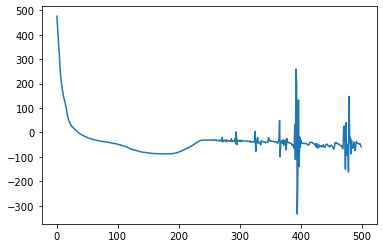

In [90]:
%matplotlib inline
plt.plot(train_loss)
plt.show()

# get z
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 3))
envs_samp = np.zeros((len(train_loader)*128, 4))
i = 0
for x,y,e in loader:
    _, _, _, z = net_icarl.forward(x.float(), y.float(), e.float(), beta=1)
    latent_variables[i*128:i*128+128,:] = z.detach()
    envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
    i+=1
    
df_icarl=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
df_icarl.columns = ['Z1', 'Z2', 'Z3', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m_icarl=df_icarl['Env'].map(colors)
df_icarl['c']=m

pdf_icarl=df_icarl[['Z1', 'Z2', 'Z3']]
pdf_icarl.columns = ['pZ1', 'pZ2', 'pZ3']
#cdf=tdf[['Z1', 'Z2', 'Z3']].iloc[4000:7968,:]
cdf_icarl=tdf[['Z1', 'Z2', 'Z3']].iloc[2000:3920,:]
cdf_icarl['pZ1']=pdf_icarl['pZ1'].values
cdf_icarl['pZ2']=pdf_icarl['pZ2'].values
cdf_icarl['pZ3']=pdf_icarl['pZ3'].values
#df.round(2)

In [91]:
# Calculate MCC
mcc_icarl = MCC(cdf_icarl.iloc[:,:3].values, pdf_icarl.values)
MCC(cdf_icarl.iloc[:,:3].values, pdf_icarl.values)

[0.9597655430887512, 0.9031165099164353, 0.03710577954826389]
[0.9597655430887512, 0.9031165099164353, 0.03710577954826389]


0.6333292775178168

## 2.4 Summary of results of the three methods ##


### 2.4.1 Posterior plots ###

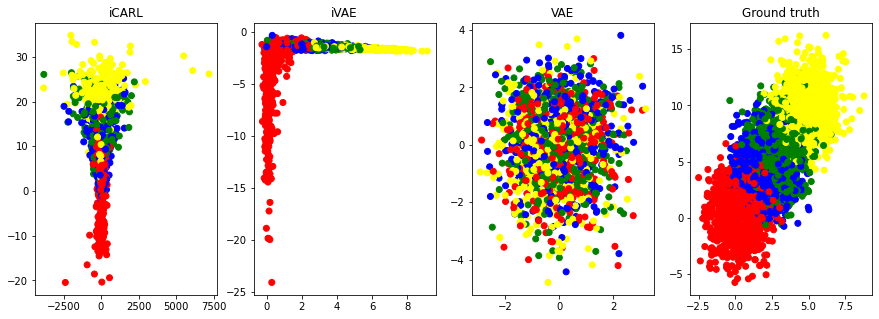

In [92]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

ax1.scatter(df_icarl['Z1'], df_icarl['Z2'], c=m_icarl)
ax1.set_title('iCARL')
ax2.scatter(df_ivae['Z1'], df_ivae['Z2'], c=m_ivae)
ax2.set_title('iVAE')
ax3.scatter(df_vae['Z1'], df_vae['Z2'], c=m_vae)
ax3.set_title('VAE')
ax4.scatter(df['Z1'], df['Z2'], c=m)
ax4.set_title('Ground truth')
plt.show()

### 2.4.2 MCC ###

<BarContainer object of 3 artists>

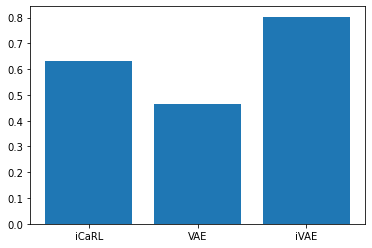

In [93]:
mccs=np.array([mcc_icarl, mcc_vae, mcc_ivae])
plt.bar(['iCaRL', 'VAE', 'iVAE'], mccs)

# 3. Case with just 2 latent variables #
In this section the third latent variable (child of y) has been omitted and the autoencoders are once more used to regenerate the latent variables.

In [94]:
# Data Generation
E_choice, Env, Y, Z = generate_z_and_y(np.array([0.2, 2, 3, 5]), 4000, three_z=False)

In [95]:
# Formatting data
df=pd.concat([p(Z), p(Y), p(Env), p(E_choice)],axis=1)
df.columns = ['Z1', 'Z2', 'Y', 'Env_mean', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m=df['Env'].map(colors)
df['c']=m
tdf=df
#df.round(2)

We can plot the generated data to observe how the classes overlap.

Text(0, 0.5, 'Z2-axis')

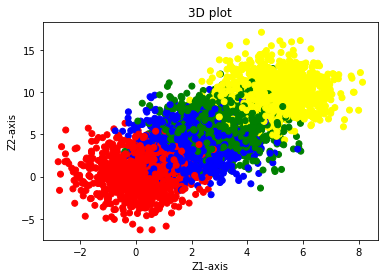

In [96]:
#%matplotlib qt
#plot_latent_3d(df, m)

fig = plt.figure()
# creating the plot
plt.scatter(df['Z1'], df['Z2'], c=m)
# setting title and labels
plt.title("3D plot")
plt.xlabel('Z1-axis')
plt.ylabel('Z2-axis')

Next, we can regenerate the X data, now for two latent variables. We can also set up the datasets to be input to the neural networks.

In [97]:
# Generate X data
net=Net1(2, 6, 10)
X=net(torch.from_numpy(Z.astype("float32"))).detach().numpy()

# Format data for neural networks
dset = EnvDataset(X[:2000],Y[:2000],E_choice[:2000])
train_loader = DataLoader(dset, batch_size=128, drop_last=True)
dset = EnvDataset(X[2000:],Y[2000:],E_choice[2000:])
test_loader = DataLoader(dset, batch_size=128, drop_last=True)
x,y,e = next(iter(train_loader))

Now, we can set the hyperparameters for the NN. 

In [99]:
z_dim = 2
x_y_e = 15
x_dim = 10
ye_dim = 5
y_dim = 1

## 3.1 Running the models ##
In each subsection, we will use the VAE classes defined in Section 2 to train and test data created with two latent variables. 

### 3.1.1 VAE ###

In [ ]:
z_dim=2
x_y_e=15
x_dim=10
net_vae=VAE(x.float(), y.float(), e.float(), x_y_e, z_dim, z_dim, x_dim, 5, z_dim, beta=1)


optimizer = Adam(net_vae.parameters(), lr=1e-3)

epochs = 100
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)

for epoch in range(epochs):
    epoch_loss = 0
    if epoch < 20:
        beta = 10
    else:
        beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss = net_vae.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)

In [ ]:
# get z
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 2))
envs_samp = np.zeros((len(train_loader)*128, 4))
i = 0
for x,y,e in loader:
    #_, _, _, _, _, z = net.forward(x.float(), y.float(), e.float(), beta=1)
    zu, zsigma, de_u, z, prior_params = net_vae.forward(x.float(), y.float(), e.float(), beta=1)
    latent_variables[i*128:i*128+128,:] = z.detach()
    envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
    i+=1
    
df_vae=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
df_vae.columns = ['Z1', 'Z2', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m_vae=df_vae['Env'].map(colors)
df_vae['c']=m
#df.round(2)

In [ ]:
pdf_vae=df_vae[['Z1', 'Z2']]
pdf_vae.columns = ['pZ1', 'pZ2']
cdf_vae=tdf[['Z1', 'Z2']].iloc[2000:3920,:]
#cdf=tdf[['Z1', 'Z2', 'Z3']].iloc[:1920,:]
cdf_vae['pZ1']=pdf_vae['pZ1'].values
cdf_vae['pZ2']=pdf_vae['pZ2'].values

In [ ]:
# Calculate MCC
mcc_vae=MCC(cdf_vae.iloc[:,:2].values, pdf_vae.values)
MCC(cdf_vae.iloc[:,:2].values, pdf_vae.values)

### 3.1.2 iVAE ###


C:\Users\mathi\anaconda3\envs\BackDec2022\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class '__main__.Normal_dist'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Epoch 20 of 100
Train loss: tensor(34.0195)
Epoch 40 of 100
Train loss: tensor(9.6285)
Epoch 60 of 100
Train loss: tensor(4.1284)
Epoch 80 of 100
Train loss: tensor(2.1225)
Epoch 100 of 100
Train loss: tensor(0.7879)


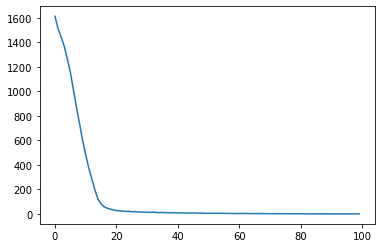

In [127]:
net_ivae=iVAE(x.float(), y.float(), e.float(), x_y_e, z_dim, z_dim, x_dim, 5, z_dim, beta=1)
x,y,e = next(iter(train_loader))

optimizer = Adam(net_ivae.parameters(), lr=1e-3)

epochs = 100
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)

for epoch in range(epochs):
    epoch_loss = 0
    if epoch < 20:
        beta = 10
    else:
        beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss = net_ivae.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)
    
plt.plot(train_loss)
plt.show()


In [128]:
# get z
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 2))
envs_samp = np.zeros((len(train_loader)*128, 4))
i = 0
for x,y,e in loader:
    _, _, _, _, _, z = net_ivae.forward(x.float(), y.float(), e.float(), beta=1)
    latent_variables[i*128:i*128+128,:] = z.detach()
    envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
    i+=1
    
df_ivae=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
df_ivae.columns = ['Z1', 'Z2', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m_ivae=df_ivae['Env'].map(colors)
df_ivae['c']=m
#df.round(2)

In [129]:
# Merge dataframes together
pdf_ivae=df_ivae[['Z1', 'Z2']]
pdf_ivae.columns = ['pZ1', 'pZ2']
cdf_ivae=tdf[['Z1', 'Z2']].iloc[2000:3920,:]
cdf_ivae['pZ1']=pdf_ivae['pZ1'].values
cdf_ivae['pZ2']=pdf_ivae['pZ2'].values

In [130]:
# Calculate MCC
mcc_ivae=MCC(cdf_ivae.iloc[:,:2].values, pdf_ivae.values)
MCC(cdf_ivae.iloc[:,:2].values, pdf_ivae.values)

[0.9303530944973922, 0.9061029421679225]
[0.9303530944973922, 0.9061029421679225]


0.9182280183326574

### 3.1.3 NF-VAE ###

In [ ]:
z_dim = 2
x_y_e = 15
x_dim = 10
ye_dim = 5
y_dim = 1
net_icarl=iCARL(x.float(), y.float(), e.float(), x_y_e, z_dim, z_dim, x_dim, ye_dim, z_dim, y_dim, beta=1)

optimizer = Adam(net_icarl.parameters(), lr=1e-3)

epochs = 100
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)

for epoch in range(epochs):
    epoch_loss = 0
    if epoch < 20:
        beta = 10
    else:
        beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss, elbo, SM = net_icarl.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)

In [ ]:
%matplotlib inline
plt.plot(train_loss)
plt.show()

# get z
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 2))
envs_samp = np.zeros((len(train_loader)*128, 4))
i = 0
for x,y,e in loader:
    _, _, _, z = net_icarl.forward(x.float(), y.float(), e.float(), beta=1)
    latent_variables[i*128:i*128+128,:] = z.detach()
    envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
    i+=1
    
df_icarl=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
df_icarl.columns = ['Z1', 'Z2', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m_icarl=df_icarl['Env'].map(colors)
df_icarl['c']=m

pdf_icarl=df_icarl[['Z1', 'Z2']]
pdf_icarl.columns = ['pZ1', 'pZ2']
cdf_icarl=tdf[['Z1', 'Z2']].iloc[2000:3920,:]
cdf_icarl['pZ1']=pdf_icarl['pZ1'].values
cdf_icarl['pZ2']=pdf_icarl['pZ2'].values
#df.round(2)

In [124]:
# Calculate MCC
mcc_icarl = MCC(cdf_icarl.iloc[:,:2].values, pdf_icarl.values)
MCC(cdf_icarl.iloc[:,:2].values, pdf_icarl.values)

[0.31769216761448704, 0.7468932230338517]
[0.31769216761448704, 0.7468932230338517]


0.5322926953241693

## 2.4 Summary of results of the three methods ##

### 2.4.1 Posterior plots ###

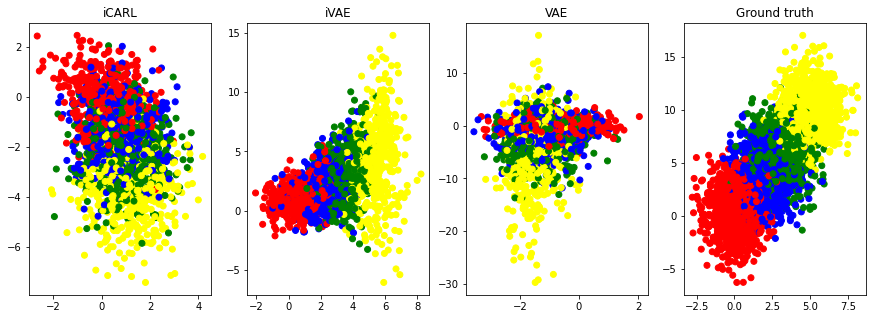

In [125]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

ax1.scatter(df_icarl['Z1'], df_icarl['Z2'], c=m_icarl)
ax1.set_title('iCARL')
ax2.scatter(df_ivae['Z1'], df_ivae['Z2'], c=m_ivae)
ax2.set_title('iVAE')
ax3.scatter(df_vae['Z1'], df_vae['Z2'], c=m_vae)
ax3.set_title('VAE')
ax4.scatter(df['Z1'], df['Z2'], c=m)
ax4.set_title('Ground truth')
plt.show()

### 2.4.2 MCC ###

<BarContainer object of 3 artists>

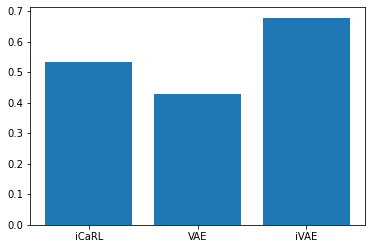

In [126]:
mccs=np.array([mcc_icarl, mcc_vae, mcc_ivae])
plt.bar(['iCaRL', 'VAE', 'iVAE'], mccs)